#Setup Library

In [ ]:
pip install neuralforecast

In [2]:
%%capture
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS, RNN
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

#Date Preprocessing

In [3]:
Y_df = pd.read_csv('/content/Merged File PM2-5.csv')

In [4]:
Y_df = Y_df.drop('Unnamed: 0' ,axis=1)

In [5]:
Y_df.isnull().sum()

Date       0
54T     1683
36T     1034
30T     1067
24T     1468
        ... 
94T     4202
95T     4202
96T     4182
97T     4206
98T     4206
Length: 104, dtype: int64

In [6]:
Y_df

,Date,54T,36T,30T,24T,44T,27T,40T,61T,26T,...,99T,103T,101T,102T,100T,94T,95T,96T,97T,98T
0,2011-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4378,2022-12-27,36.0,33.0,45.0,46.0,23.0,46.0,21.0,28.0,45.0,...,32.0,42.0,24.0,11.0,27.0,35.0,43.0,44.0,30.0,38.0
4379,2022-12-28,42.0,32.0,48.0,43.0,26.0,56.0,23.0,30.0,51.0,...,31.0,40.0,20.0,11.0,22.0,34.0,36.0,41.0,29.0,39.0
4380,2022-12-29,43.0,31.0,47.0,34.0,26.0,49.0,21.0,29.0,46.0,...,28.0,38.0,13.0,12.0,26.0,30.0,36.0,45.0,26.0,36.0
4381,2022-12-30,27.0,31.0,33.0,23.0,27.0,32.0,20.0,20.0,40.0,...,17.0,41.0,17.0,12.0,14.0,26.0,28.0,37.0,22.0,28.0


In [7]:
Y_df['unique_id'] = 1.0

In [8]:
Y_df = Y_df[['unique_id', 'Date', '35T']] #Select one station

In [9]:
Y_df.head()

,unique_id,Date,35T
0,1.0,2011-01-01,NaN
1,1.0,2011-01-02,NaN
2,1.0,2011-01-03,NaN
3,1.0,2011-01-04,NaN
4,1.0,2011-01-05,NaN


In [10]:
Y_df.rename(columns = {'Date' : 'ds', '35T' : 'y'}, inplace = True)

In [11]:
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

In [12]:
Y_df.dtypes

unique_id           float64
ds           datetime64[ns]
y                   float64
dtype: object

In [13]:
Y_df = Y_df.dropna()
Y_df

,unique_id,ds,y
2018,1.0,2016-07-11,20.0
2019,1.0,2016-07-12,24.0
2020,1.0,2016-07-13,26.0
2021,1.0,2016-07-14,23.0
2022,1.0,2016-07-15,24.0
...,...,...,...
4378,1.0,2022-12-27,33.0
4379,1.0,2022-12-28,32.0
4380,1.0,2022-12-29,34.0
4381,1.0,2022-12-30,32.0


In [14]:
Y_df = Y_df.reset_index()

In [15]:
Y_df.columns

Index(['index', 'unique_id', 'ds', 'y'], dtype='object')

In [16]:
Y_df = Y_df.drop(['index'] ,axis=1)

In [17]:
Y_df

,unique_id,ds,y
0,1.0,2016-07-11,20.0
1,1.0,2016-07-12,24.0
2,1.0,2016-07-13,26.0
3,1.0,2016-07-14,23.0
4,1.0,2016-07-15,24.0
...,...,...,...
2288,1.0,2022-12-27,33.0
2289,1.0,2022-12-28,32.0
2290,1.0,2022-12-29,34.0
2291,1.0,2022-12-30,32.0


In [18]:
Y_train_df = Y_df.loc[Y_df['ds'] <= '2022-01-01']
Y_test_df = Y_df.loc[Y_df['ds'] > '2022-01-01']

In [19]:
len(Y_test_df)

340

In [20]:
len(Y_train_df)

1953

In [21]:
Y_train_df.tail()

,unique_id,ds,y
1948,1.0,2021-12-28,25.0
1949,1.0,2021-12-29,21.0
1950,1.0,2021-12-30,21.0
1951,1.0,2021-12-31,22.0
1952,1.0,2022-01-01,28.0


In [22]:
Y_test_df.isnull().sum()

unique_id    0
ds           0
y            0
dtype: int64

#Training and Evaluation

In [23]:
%%capture
horizon = len(Y_test_df)

# Try different hyperparmeters to improve accuracy.
models = [LSTM(h=horizon,                    # Forecast horizon
               max_steps=500,                # Number of steps to train
               scaler_type='standard',       # Type of scaler to normalize data
               encoder_hidden_size=64,       # Defines the size of the hidden state of the LSTM
               decoder_hidden_size=64,),     # Defines the number of hidden units of each layer of the MLP decoder
          NHITS(h=horizon,                   # Forecast horizon
                input_size=2 * horizon,      # Length of input sequence
                max_steps=100,               # Number of steps to train
                n_freq_downsample=[2, 1, 1]), # Downsampling factors for each stack output
          RNN(h=horizon,
              scaler_type='robust',
                encoder_n_layers=2,
                encoder_hidden_size=128,
                context_size=10,
                decoder_hidden_size=128,
                decoder_layers=2,
                max_steps=300)
          ]
nf = NeuralForecast(models=models, freq='D')
nf.fit(df=Y_train_df)

INFO:lightning_fabric.utilities.seed:Global seed set to 1
INFO:lightning_fabric.utilities.seed:Global seed set to 1
INFO:lightning_fabric.utilities.seed:Global seed set to 1


In [24]:
Y_hat_df = nf.predict()

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [25]:
Y_hat_df = Y_hat_df.reset_index()
Y_hat_df.head()

,unique_id,ds,LSTM,NHITS,RNN
0,1.0,2022-01-02,29.739281,29.093580,23.073353
1,1.0,2022-01-03,28.854456,29.144650,23.026093
2,1.0,2022-01-04,29.545261,28.538929,23.107483
3,1.0,2022-01-05,29.226225,30.421003,21.622704
4,1.0,2022-01-06,30.278172,31.038940,22.597631


In [26]:
Y_hat_df.tail()

,unique_id,ds,LSTM,NHITS,RNN
335,1.0,2022-12-03,29.315647,23.949644,19.637234
336,1.0,2022-12-04,28.716822,23.734240,19.247810
337,1.0,2022-12-05,29.773186,24.574402,19.910877
338,1.0,2022-12-06,28.731426,24.306385,18.665661
339,1.0,2022-12-07,28.723253,23.734112,18.917793


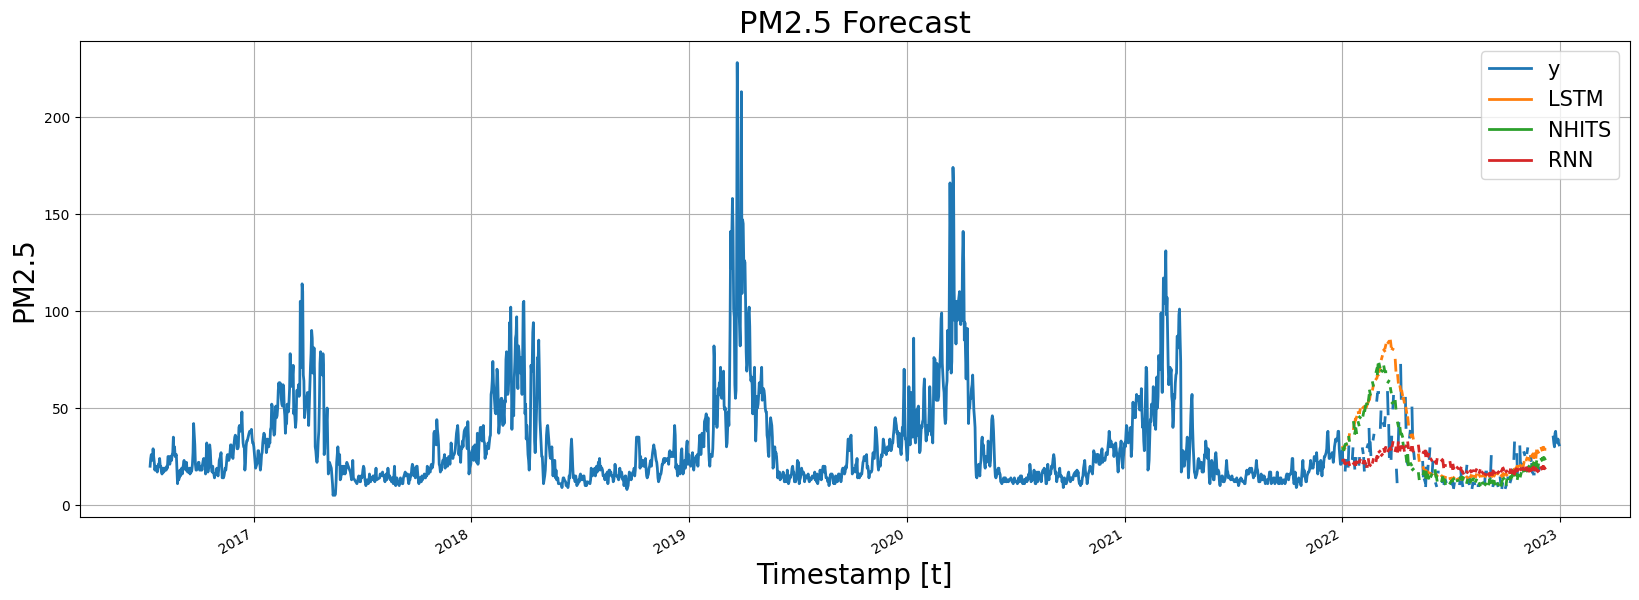

In [27]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = pd.concat([Y_df, Y_hat_df]).set_index('ds') # Concatenate the train and forecast dataframes
plot_df[['y', 'LSTM', 'NHITS', 'RNN']].plot(ax=ax, linewidth=2)

ax.set_title('PM2.5 Forecast', fontsize=22)
ax.set_ylabel('PM2.5', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [42]:
mae = mean_absolute_error(Y_test_df['y'], Y_hat_df['LSTM'])
mape = mean_absolute_percentage_error(Y_test_df['y'], Y_hat_df['LSTM'])
rmse = np.sqrt(mean_squared_error(Y_test_df['y'], Y_hat_df['LSTM']))

mae2 = mean_absolute_error(Y_test_df['y'], Y_hat_df['NHITS'])
mape2 = mean_absolute_percentage_error(Y_test_df['y'], Y_hat_df['NHITS'])
rmse2 = np.sqrt(mean_squared_error(Y_test_df['y'], Y_hat_df['NHITS']))

mae3 = mean_absolute_error(Y_test_df['y'], Y_hat_df['RNN'])
mape3 = mean_absolute_percentage_error(Y_test_df['y'], Y_hat_df['RNN'])
rmse3 = np.sqrt(mean_squared_error(Y_test_df['y'], Y_hat_df['RNN']))

print(f'mae - LSTM: {mae}')
print(f'mape - LSTM: {mape}')
print(f'rmse - LSTM: {rmse}')
print('=======')
print(f'mae - NHITS: {mae2}')
print(f'mape - NHITS: {mape2}')
print(f'rmse - NHITS: {rmse2}')
print('=======')
print(f'mae - RNN: {mae3}')
print(f'mape - RNN: {mape3}')
print(f'rmse - RNN: {rmse3}')

mae - LSTM: 10.852667087667129
mape - LSTM: 0.4920342443165451
rmse - LSTM: 16.599536857437464
mae - NHITS: 9.534938116634594
mape - NHITS: 0.39627575966931694
rmse - NHITS: 13.841450482358695
mae - RNN: 8.219181268355426
mape - RNN: 0.4086957481812309
rmse - RNN: 11.023417062232847


#Save and Load Model

In [34]:
nf.save(path='./checkpoints1/neutralforecast_v2',
        model_index=None, 
        overwrite=True,
        save_dataset=True)

In [ ]:
!zip -r /content/neutralforecast_v2.zip /content/checkpoints1

In [ ]:
!unzip /content/neutralforecast_v2.zip -d /loaded_model/

In [39]:
nf2 = NeuralForecast.load(path='/content/checkpoints1/neutralforecast_v2')
Y_hat_df = nf2.predict().reset_index()
Y_hat_df.head()

INFO:lightning_fabric.utilities.seed:Global seed set to 1
INFO:lightning_fabric.utilities.seed:Global seed set to 1
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

,unique_id,ds,RNN,LSTM,NHITS
0,1.0,2022-01-02,23.073353,29.739281,29.093580
1,1.0,2022-01-03,23.026093,28.854456,29.144650
2,1.0,2022-01-04,23.107483,29.545261,28.538929
3,1.0,2022-01-05,21.622704,29.226225,30.421003
4,1.0,2022-01-06,22.597631,30.278172,31.038940
